In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA, KernelPCA, IncrementalPCA
from sklearn.datasets import make_swiss_roll
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


In [2]:
# Retrieve and load the MNIST dataset
mnist = fetch_openml('mnist_784')


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [19]:
# Split the data into a training set (first 60,000 instances)
x_train, y_train = mnist.data[:60000].to_numpy(), mnist.target[:60000].to_numpy()


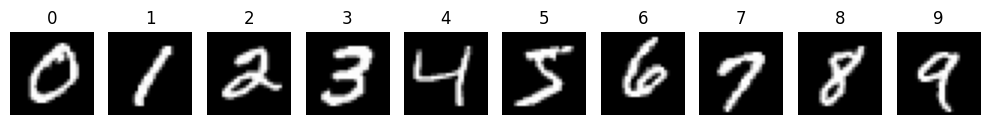

In [4]:
# Display each digit using subplots
fig, axes = plt.subplots(1, 10, figsize=(10, 2))
for i in range(10):
    idx = np.where(y_train == str(i))[0][0]
    axes[i].imshow(x_train[idx].reshape(28, 28), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(str(i))
plt.tight_layout()
plt.show()

In [5]:
# Split the data into a test set (last 10,000 instances)
x_test, y_test = mnist.data[60000:], mnist.target[60000:]

In [6]:
# Use PCA to extract the first two principal components
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_train)

In [7]:
# Print the explained variance ratio of the two principal components
explained_variance_ratio = pca.explained_variance_ratio_
print(explained_variance_ratio)


[0.09704664 0.07095924]


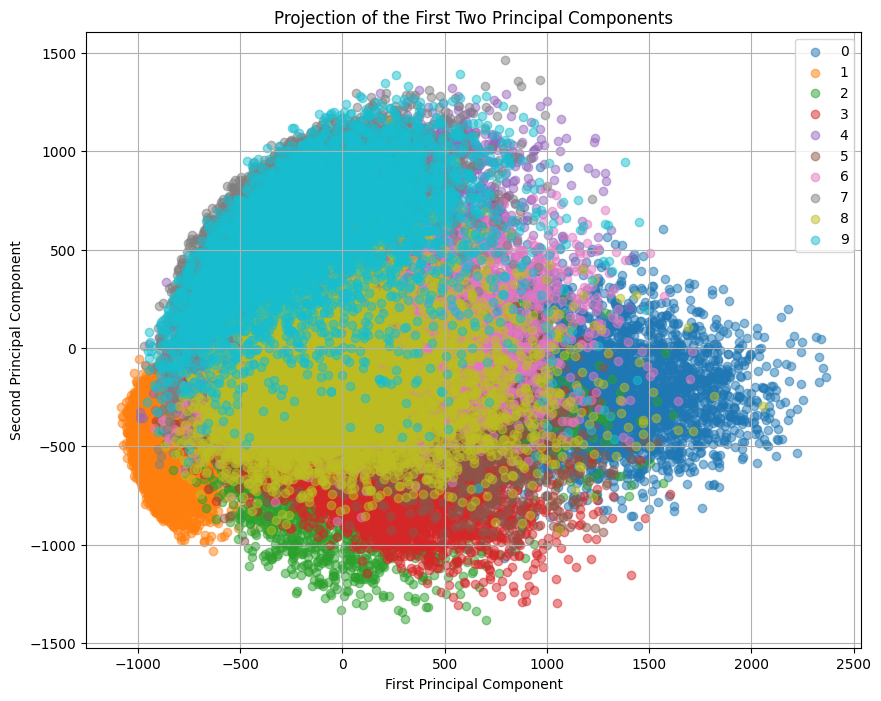

In [8]:
# Plot the projections of the first two principal components on a 2D plane
plt.figure(figsize=(10, 8))
for i in range(10):
    plt.scatter(x_pca[y_train == str(i), 0], x_pca[y_train == str(i), 1], alpha=0.5, label=str(i))
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Projection of the First Two Principal Components')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Reducing the dimensionality of the MNIST dataset to 154 dimensions using Incremental PCA
n_batches = 100
ipca = IncrementalPCA(n_components=154)
for x_batch in np.array_split(x_train, n_batches):
    ipca.partial_fit(x_batch)
x_ipca = ipca.transform(x_train)

<ipython-input-10-0f1dcf7e8e55>:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


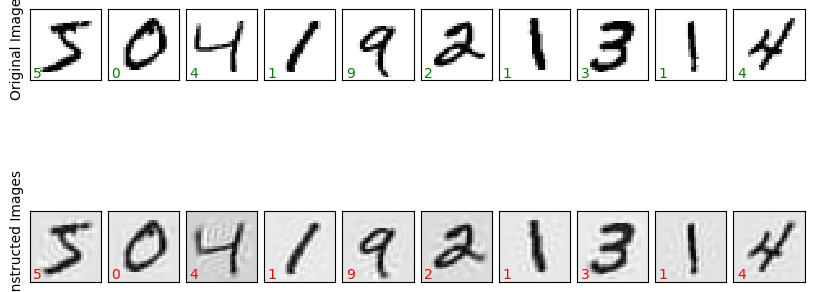

In [10]:
# Display the original and the compressed digits
x_reconstructed = ipca.inverse_transform(x_ipca)
fig, axes = plt.subplots(2, 10, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []}, gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    axes[0, i].imshow(x_train[i].reshape(28, 28), cmap='binary', interpolation='nearest')
    axes[0, i].text(0.05, 0.05, str(y_train[i]), transform=axes[0, i].transAxes, color='green')
    axes[1, i].imshow(x_reconstructed[i].reshape(28, 28), cmap='binary', interpolation='nearest')
    axes[1, i].text(0.05, 0.05, str(y_train[i]), transform=axes[1, i].transAxes, color='red')
axes[0, 0].set_ylabel('Original Images')
axes[1, 0].set_ylabel('Reconstructed Images')
plt.tight_layout()
plt.show()

In [11]:
# --- Swiss Roll Dataset Tasks ---

# Generate the Swiss roll dataset
X_swiss, y_swiss = make_swiss_roll(n_samples=1000, noise=0.0, random_state=42)


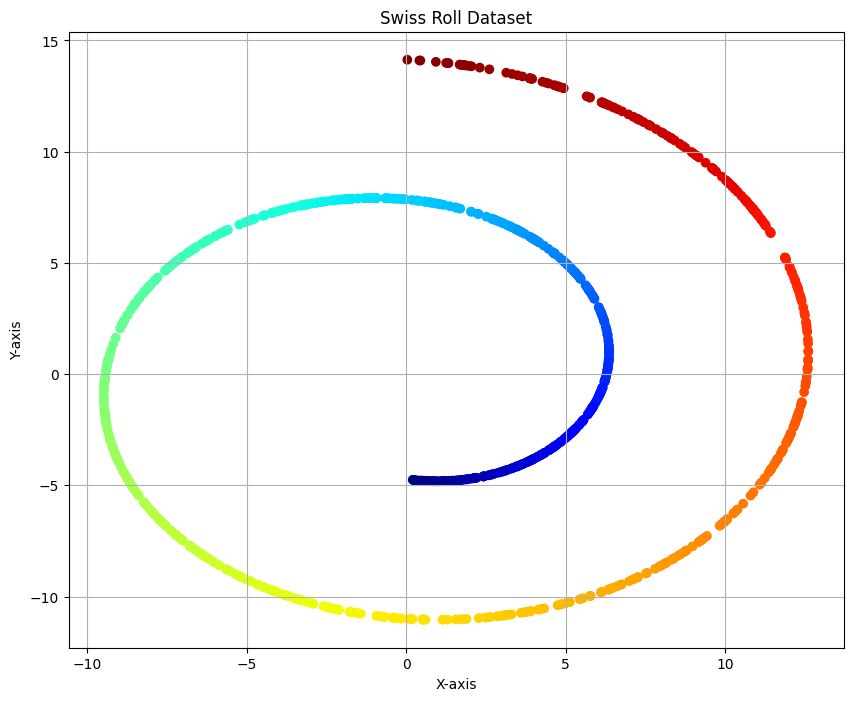

In [12]:
# Plot the generated Swiss roll dataset
plt.figure(figsize=(10, 8))
plt.scatter(X_swiss[:, 0], X_swiss[:, 2], c=y_swiss, cmap=plt.cm.jet)
plt.title("Swiss Roll Dataset")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(True)
plt.show()

In [13]:
# Apply Kernel PCA (kPCA) with different kernels: linear, RBF, and sigmoid
kernels = ['linear', 'rbf', 'sigmoid']
kpca_results = {}
for kernel in kernels:
    kpca = KernelPCA(n_components=2, kernel=kernel, gamma=0.04)
    X_kpca = kpca.fit_transform(X_swiss)
    kpca_results[kernel] = X_kpca

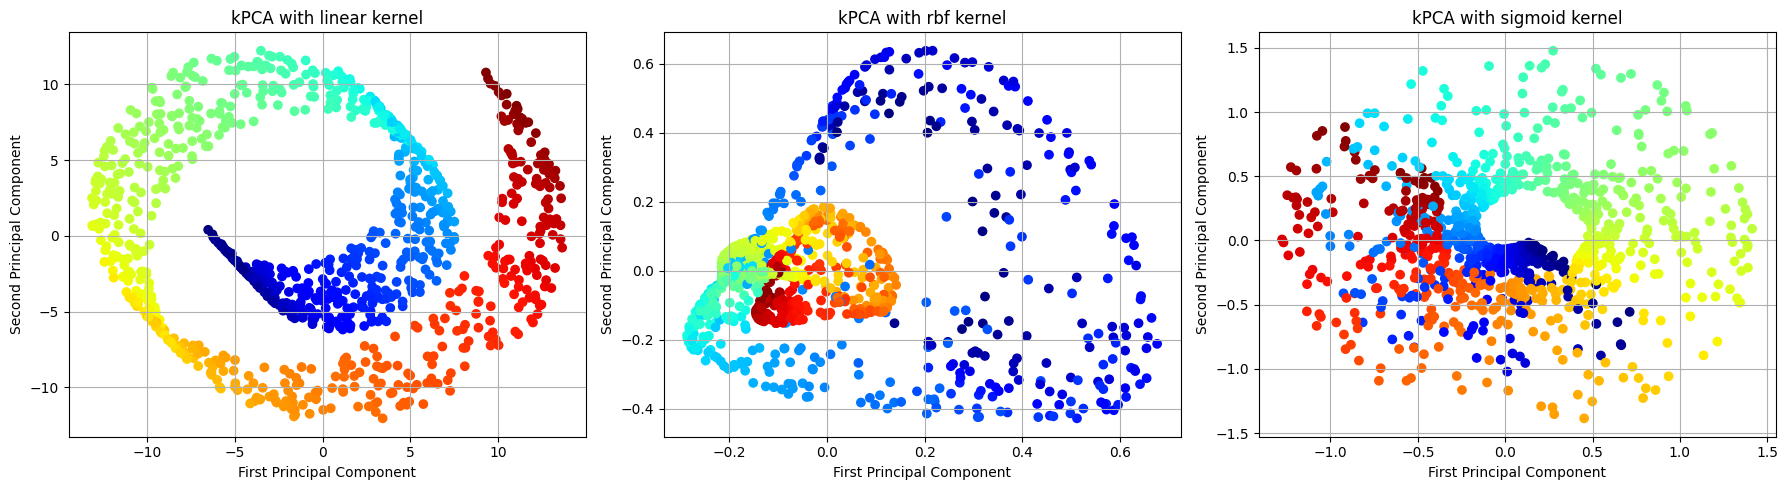

In [14]:
# Plot the results of applying kPCA with different kernels
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, kernel in enumerate(kernels):
    axes[i].scatter(kpca_results[kernel][:, 0], kpca_results[kernel][:, 1], c=y_swiss, cmap=plt.cm.jet)
    axes[i].set_title(f"kPCA with {kernel} kernel")
    axes[i].set_xlabel("First Principal Component")
    axes[i].set_ylabel("Second Principal Component")
    axes[i].grid(True)
plt.tight_layout()
plt.show()

In [18]:
import warnings

# Ignore any warning messages
warnings.filterwarnings("ignore")
# Use kPCA with Logistic Regression for classification and apply GridSearchCV
y_binned = np.digitize(y_swiss, np.linspace(y_swiss.min(), y_swiss.max(), 50))
pipeline = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression())
])
param_grid = {
    "kpca__gamma": np.linspace(0.03, 0.05, 10),
    "kpca__kernel": ["linear", "rbf", "sigmoid"]
}
grid_search = GridSearchCV(pipeline, param_grid, cv=3)
grid_search.fit(X_swiss, y_binned)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid={'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                         'kpca__kernel': ['linear', 'rbf', 'sigmoid']})

In [16]:
# Print best parameters found by GridSearchCV
best_params = grid_search.best_params_
print(best_params)

{'kpca__gamma': 0.03, 'kpca__kernel': 'linear'}


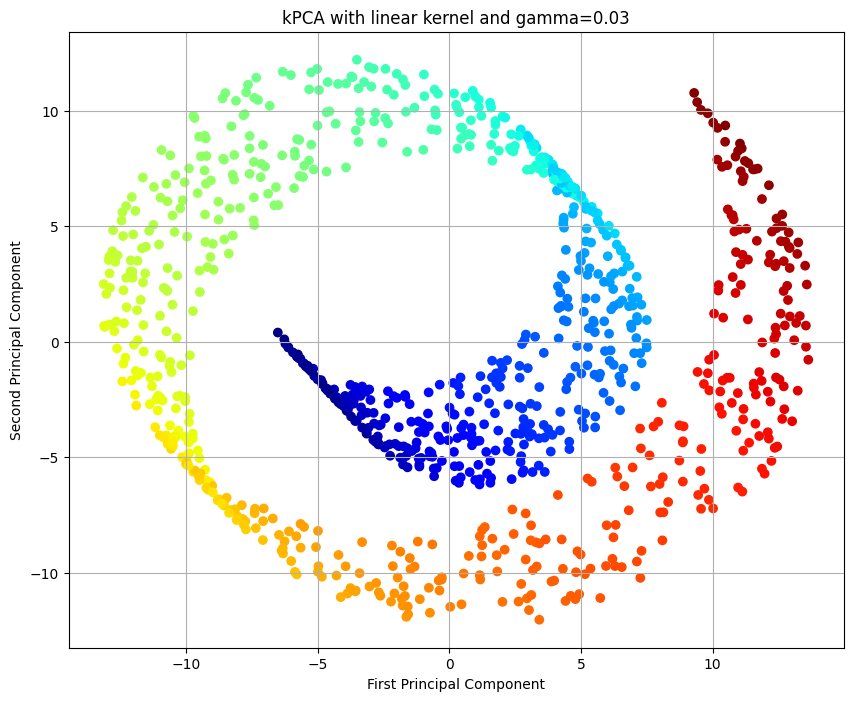

In [17]:
# Plot the results using the best parameters from GridSearchCV
kpca_best = KernelPCA(n_components=2, kernel=best_params['kpca__kernel'], gamma=best_params['kpca__gamma'])
X_kpca_best = kpca_best.fit_transform(X_swiss)
plt.figure(figsize=(10, 8))
plt.scatter(X_kpca_best[:, 0], X_kpca_best[:, 1], c=y_swiss, cmap=plt.cm.jet)
plt.title(f"kPCA with {best_params['kpca__kernel']} kernel and gamma={best_params['kpca__gamma']}")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.grid(True)
plt.show()